In [1]:
using LimberJack
using NPZ
using LinearAlgebra
using Statistics

In [2]:
function reparametrize(cosmo::CosmoPar)
    Ωc = cosmo.Ωm - cosmo.Ωb 
    wc = Ωc*cosmo.h^2
    wb = cosmo.Ωb*cosmo.h^2
    params = [wc, wb, 2.7, cosmo.n_s, cosmo.h]
    cosmotype = eltype(params)
    return cosmotype, params
end

reparametrize (generic function with 1 method)

In [18]:
xinputs = npzread("../emulator_files/xinputs.npz")["arr_0"]
yinputs = npzread("../emulator_files/yinputs.npz")["arr_0"]
hyper = npzread("../emulator_files/hypers.npz")["arr_0"]
alphas = npzread("../emulator_files/alphas.npz")["arr_0"]
k_arr = npzread("../emulator_files/k_arr.npz")["arr_0"];

In [3]:
cosmo1 = Cosmology(0.252, 0.039, 0.75, 1.0, 0.72,
                  nk=256, tk_mode="EisHu")
Pk_EisHu = lin_Pk(cosmo1, k_arr, 0.0)

LoadError: UndefVarError: k_arr not defined

In [4]:
xinputs = npzread("../emulator_files/xinputs.npz")["arr_0"]
yinputs = npzread("../emulator_files/yinputs.npz")["arr_0"]
hyper = npzread("../emulator_files/hypers.npz")["arr_0"]
alphas = npzread("../emulator_files/alphas.npz")["arr_0"]
k_arr = npzread("../emulator_files/k_arr.npz")["arr_0"];

In [5]:
nothing, param = reparametrize(cosmo1.cosmo)
param

5-element Vector{Float64}:
 0.1198125
 0.0219375
 2.7
 1.0
 0.75

In [6]:
function x_transformation(point, x_arr)
    """Pre-whiten the input parameters.

    Args:
        point (torch.tensor): the input parameters.

    Returns:
        torch.tensor: the pre-whitened parameters.
    """

    N, M = size(x_arr)
    cov_train = cov(x_arr)
    chol_train = cholesky(cov_train).U'
    mean_train = mean(x_arr, dims=1)
    # calculate the transformed training points
    transformed = inv(chol_train) * (point .- mean_train)'

    return transformed
end

function y_transformation(point, y_arr)
    """Transform the outputs.

    Args:
        yvalues (np.ndarray): the values to be transformed

    Returns:
        np.ndarray: the transformed outputs
    """
    ylog = log.(y_arr)
    ymean = mean(ylog, dims=1)
    ystd = std(ylog, dims=1)
    return ((point .- ymean) ./ ystd)'
end

function inv_y_transformation(point, y_arr)
    """Transform the outputs.

    Args:
        yvalues (np.ndarray): the values to be transformed

    Returns:
        np.ndarray: the transformed outputs
    """
    ylog = log.(y_arr)
    ystd = std(ylog, dims=1)
    ymean = mean(ylog, dims=1)
    return exp.(ystd .* point' .+ ymean)
end

inv_y_transformation (generic function with 1 method)

In [7]:
xtrain = x_transformation(xinputs, xinputs)
ytrain = y_transformation(yinputs, yinputs)
param_t = x_transformation(param', xinputs);

In [8]:
function get_kernel(arr1, arr2, hyper)
    """Compute the kernel matrix between the sets of training cosmoligical parameters
       and the desired set of cosmological parameters.
    Args:
        x1 (np.ndarray): [N x d] tensor of points.
        x2 (np.ndarray): [M x d] tensor of points.
        hyper (np.ndarray): [d+1] tensor of hyperparameters.
    Returns:
        np.ndarray: a tensor of size [N x M] containing the kernel matrix.
    """
    
    arr1_w = @.(arr1/exp(hyper[2:6]))
    arr2_w = @.(arr2/exp(hyper[2:6]))
    
    # compute the pairwise distance
    term1 = sum(arr1_w.^2, dims=1)
    term2 = 2 * arr1_w' * arr2_w
    term3 = sum(arr2_w.^2, dims=1)'
    dist = term1 - term2' .+ term3

    # compute the kernel
    kernel = @.(exp(hyper[1]) * exp(-0.5 * dist))

    return kernel
end

get_kernel (generic function with 1 method)

In [9]:
preds = []
for i in 1:40
    kernel = get_kernel(xtrain, param_t, hyper[i, :])
    mean = dot(vec(kernel), vec(alphas[i,:]))
    push!(preds, mean)
end

In [10]:
Pk_emul = vec(inv_y_transformation(preds, yinputs))

40-element Vector{Float64}:
  1054.7732239742577
  1403.523202242092
  1866.3841566166288
  2482.2471673134773
  3295.700526594644
  4371.725593778084
  5783.002933767811
  7624.304306471797
 10017.977031914463
 13067.80339925334
 16874.99780820971
 21567.133800561343
 27005.733796489614
     ⋮
   908.2101919548819
   501.7984023396445
   270.1218324531926
   142.00535917975347
    73.48823733734241
    37.37635736629521
    18.801547121995146
     9.639462049475933
     4.5904167082225324
     2.2352780755777375
     1.0808569224143112
     0.5221549078413078

In [11]:
cosmo2 = Cosmology(0.252, 0.039, 0.75, 1.0, 0.72,
                  nk=256, tk_mode="emulator")
Pk_emul_L = lin_Pk(cosmo2, k_arr, 0.0)

40-element Vector{Float64}:
  1052.2269495176104
  1400.1006837319496
  1861.8911272629182
  2476.147176779898
  3287.6844973301368
  4360.622395935465
  5768.246015020227
  7605.7093333515595
  9991.288475783096
 13030.040508769147
 16828.967717594118
 21509.000599682495
 26936.99441050055
     ⋮
   905.7546263187387
   500.33097932666226
   269.18044024590733
   141.57033834740713
    73.30098015698054
    37.272061683438956
    18.773043316664758
     9.594464720728551
     4.5807080957265995
     2.229203005882387
     1.0782035788309499
     0.520894400204188

In [12]:
using Interpolations
ks_emul, pk0_emul = get_emulated_log_pk0(cosmo2.cosmo)
pki_emul = LinearInterpolation(log.(ks_emul), log.(pk0_emul),
                               extrapolation_bc=Line())
pk0 = exp.(pki_emul(log.(cosmo.ks)));

LoadError: UndefVarError: cosmo not defined

In [13]:
function w_tophat(x::Real)
    x2 = x^2

    if x < 0.1
        w = 1. + x2*(-1.0/10.0 + x2*(1.0/280.0 +
            x2*(-1.0/15120.0 + x2*(1.0/1330560.0 +
            x2* (-1.0/172972800.0)))));
    else
        w = 3 * (sin(x)-x*cos(x))/(x2*x)
    end
    return w
end    

function _σR2(ks, pk, dlogk, R)
    x = ks .* R
    wk = w_tophat.(x)
    integ = @. pk * wk^2 * ks^3
    # OPT: proper integration instead?
    return sum(integ)*dlogk/(2*pi^2)
end

_σR2 (generic function with 1 method)

In [14]:
σ8_2_here = _σR2(ks, pk0, dlogk, 8.0/cosmo1.cosmo.h)
norm = cpar.σ8^2 / σ8_2_here


LoadError: UndefVarError: cpar not defined

In [15]:
ref = [1.05199810e+03, 1.39972787e+03, 1.86175310e+03, 2.47485290e+03,
       3.28678329e+03, 4.35879529e+03, 5.76807365e+03, 7.60883617e+03,
       9.99017257e+03, 1.30291073e+04, 1.68341153e+04, 2.14732641e+04,
       2.69244140e+04, 3.30028431e+04, 3.92692797e+04, 4.49267904e+04,
       4.87473257e+04, 4.91726610e+04, 4.49690394e+04, 3.67747863e+04,
       2.82780596e+04, 2.29757121e+04, 1.74933110e+04, 1.07923121e+04,
       7.73217085e+03, 4.73490310e+03, 2.81547163e+03, 1.63726622e+03,
       9.16888584e+02, 5.03788217e+02, 2.70399989e+02, 1.42297928e+02,
       7.35961443e+01, 3.74882941e+01, 1.88420637e+01, 9.35899651e+00,
       4.60024344e+00, 2.24010663e+00, 1.08184944e+00, 5.18425752e-01];

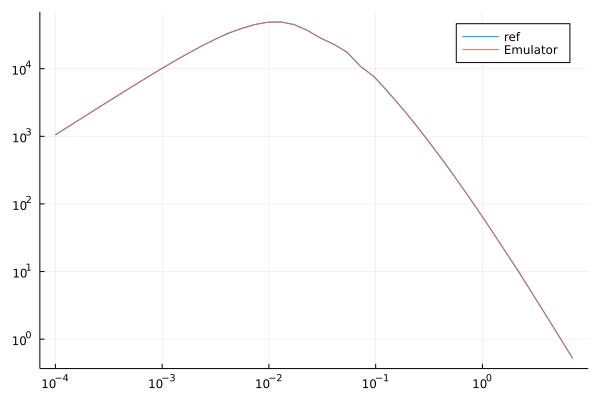

In [17]:
using Plots
#plot(k_arr, Pk_EisHu, xaxis=:log, yaxis=:log, label="EisHu")
plot(k_arr, ref, xaxis=:log, yaxis=:log, label="ref")
plot!(k_arr, Pk_emul_L, xaxis=:log, yaxis=:log, label="Emulator")

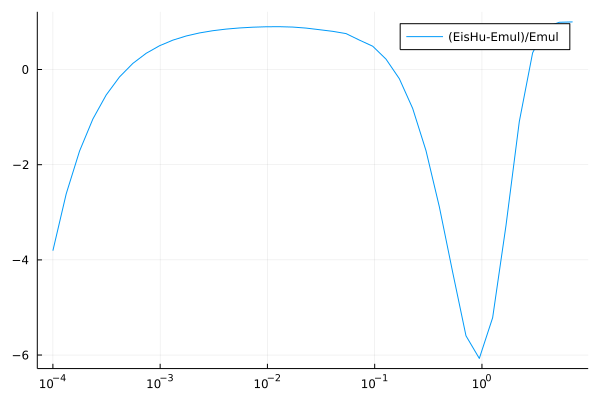

In [13]:
plot(k_arr, (Pk_EisHu-Pk_emul_L)./Pk_EisHu, xaxis=:log, label="(EisHu-Emul)/Emul")

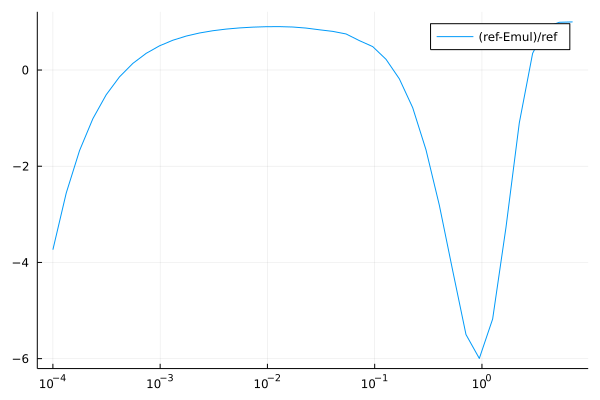

In [14]:
plot(k_arr, (ref-Pk_emul_L)./ref, xaxis=:log, label="(ref-Emul)/ref")

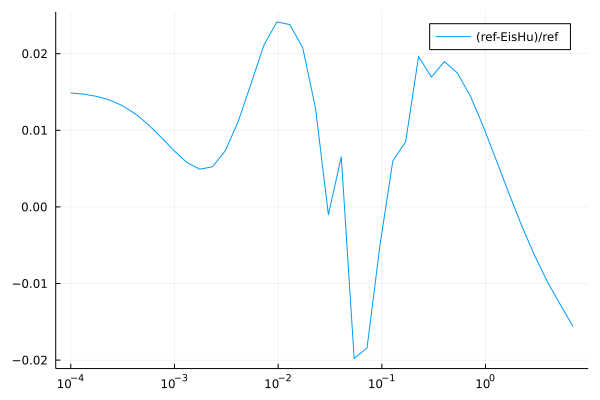

In [15]:
plot(k_arr, (ref-Pk_EisHu)./ref, xaxis=:log, label="(ref-EisHu)/ref")